# "DataBlock Playground"
> "This is an extension of the DataBlock Tutorial"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

We will see how to build DataBlocks with fastai.

Familiarize yourself with the following resources:
* [fastai and the New DataBlock API - Zachary Mueller](https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html)
* [Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD Chapter 11](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527)
* [fastai tutorial](https://github.com/fastai/fastai2/blob/master/nbs/50_tutorial.datablock.ipynb)
* [DataBlocks API - A high level introduction with examples - Aman Arora](https://amaarora.github.io/fastaiexplained/fastai/datablocksapi/dataload/2020/03/24/DataBlocks-API.html) 
   

For more practice open this in Google Collaboratory. I attempt to give a high level explanation in the `Experiments` section. You have tiny versions of the datasets so you don't have to bother about getting the data from Kaggle etc just download it form [here](https://github.com/rekil156/data). 

In [0]:
#hide
# fastai2 Version: 0.0.13
!pip install fastai2 -q
from fastai2.vision.all import *

Currently we'll focus on how how we can use source(paths or dfs) and set our get_x, get_y, get_items.  

Splitters and Item/Batch Tfms - will update later

# Single label classification  

[MNIST](http://yann.lecun.com/exdb/mnist/)  
(ImageBlock(cls=PILImageBW), CategoryBlock

In [0]:
#hide
path = untar_data(URLs.MNIST_TINY)
!ls {path}

labels.csv  models  test  train  valid


We have a `csv` that contains our `filenames` and `labels`

In [0]:
#hide_input 
df = pd.read_csv(path/'labels.csv')
df.head(2)

,name,label
0,train/3/7463.png,3
1,train/3/9829.png,3


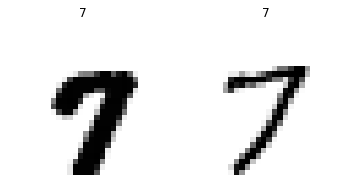

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dl = mnist.dataloaders(df)
dl.show_batch(max_n=2)


### Experiments, high level understanding

### Experiment 1) Let's change `ImageBlock(cls=PILImageBW)` to `ImageBlock()`

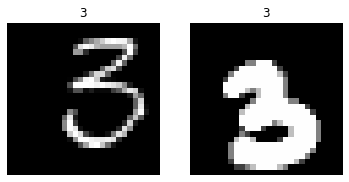

In [0]:
mnist = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

Wow that seems to work too.We see '3' and '7'.   
Hang on it looks different though, the colors are inverted.   
What is happening?  
Let's look at ImageBlock. (??ImageBlock)
```
def ImageBlock(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
```
The default cls is PILImage which is an RGB image. For single channel images you want to pass cls=PILImageBW. Later we'll see how we pass in a 4-channel image.
Other thing to notice in the `Imageblock` code is `type_tfms=cls.create` and `batch_tfms=IntToFloatTensor` we'll discuss that shortly.

### Experiment 2) Change CategoryBlock to  CategoryBlock()

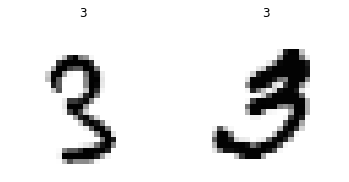

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

This looks good. The answer is in ??DataBlock.  
`blocks = L(b() if callable(b) else b for b in blocks)`

### Experiment 3) Let's experiment with `item_tfms`.  
What is the differnce between `item_tfms` and `batch_tfms` ?     
We want to harness the power of the GPU(`batch_tfms`). You could pass a single image to the GPU but that is not the most efficient use of the GPU.Passing in a `batch` of images is when the GPU shines (there is an upper limit based on your GPU). The requirement for a batch is that all the individual images should be of the same shape so that they can be collated.      
So how do we resize each image to a fixed size?    
`item_tfms`(applied on the CPU) are used for this. 

So let us check this behaviour. For this experiment let us remove the `item_tfms` ie `item_tfms = [CropPad(34),RandomCrop(28)],` and we whould expect it to give an error. Let us see:

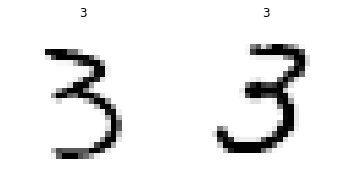

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  batch_tfms = [Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

Why did it not break?   
In our current MNIST example all the images happen to be of the same size so we didn't have to resize it.   

We can test this with the [Pets example](https://github.com/fastai/fastai2/blob/master/nbs/50_tutorial.datablock.ipynb).  
You should get a rather non-cryptic error message - `Sizes of tensors must match except in dimension 0. Got 375 and 500 in dimension 2`.  

`"Sizes of tensors must match except in dimension 0"` basically this means your batch can be of any size but the number of channels, width and height should be the same for all the images. 

### Experiment 4)What are the batch tranforms that are being applied?   
We asked for `Normalize`. Let's check

In [0]:
dls.train.after_batch

Pipeline: IntToFloatTensor -> Normalize

Rememeber what we saw in ??ImageBlock - `batch_tfms=IntToFloatTensor`.   
That is being applied automatically for us. Look at `default_batch_tfms`  in ??DataBlock. The different blocks come with default batch transforms and default item transforms, `default_item_tfms`. 
So now replace ` batch_tfms = [Normalize()]` with ` batch_tfms = [IntToFloatTensor(),Normalize()]`. That works too.   


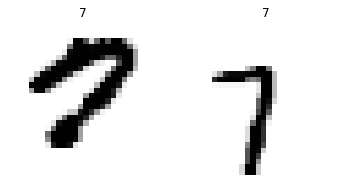

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
                  get_x=ColReader(0, pref=f'{path}/'),
                  get_y=ColReader(1),
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [IntToFloatTensor(),Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

But wait, didn't we apply `IntToFloatTensor`  twice ?   
Don't worry duplicates are removed look at `_merge_tfms` in `block.py`.    
So the different `TransformBlocks`  may have different default type_tfms, item_tfms, batch_tfms. 

Similarly `ToTensor()` is applied automatically for `item_tfms`.  
Let's look at ??TransformBlock   
```
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
```

### Experiment 5)Let us look at `getters`.  
Replace 
```
 get_x=ColReader(0, pref=f'{path}/'),
 get_y=ColReader(1),
```
with 
```
getters = [ColReader(0, pref=f'{path}/'),ColReader(1)],
                  

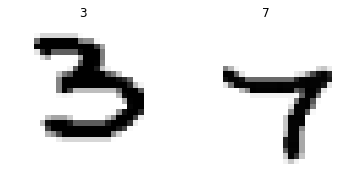

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()),
                  getters = [ColReader(0, pref=f'{path}/'),ColReader(1)],
                  splitter =RandomSplitter(),
                  item_tfms = [CropPad(34),RandomCrop(28)],
                  batch_tfms = [IntToFloatTensor(),Normalize()],
                  )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

So that works too, let's look at ??DataBlock
```
if self.get_x: self.getters[0] = self.get_x
if self.get_y: self.getters[1] = self.get_y
```

The `get_x` and `get_y` basically set the `getters`.

## Now lets try the same dataset with get_items

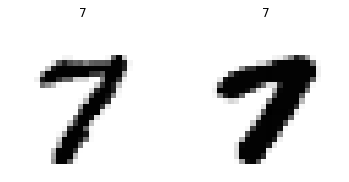

In [0]:
def _mnist_items(x): 
  return (f'{path}/'+x.name,x.label)

mnist = DataBlock.from_columns(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items = _mnist_items,
                  splitter =RandomSplitter(),
                   )
dls = mnist.dataloaders(df)
dls.show_batch(max_n=2)

Note: the `from_columns` in `DataBlock.from_columns` 


 We need a x and y to train. More specifically we need a Tuple ie (x,y).    
Our x are image names in column 'name'.(we need the full path to grab the image)   
Our y are the labels in column 'labels'.  

See what `_mnist_items(df)` gives you.   

In [0]:
df.name[0], df.label[0]

('train/3/7463.png', 3)

In [0]:
df.values[0]

array(['train/3/7463.png', 3], dtype=object)

### Example for `get_x` and `get_y` can be a list of functions.  
We saw in Experiment 4(above) that `batch_tfms` and `item_tfms` can be a list of funtions.  
Similarly `get_x` and `get_y` can be a list of functions too.  
[The Idea of a Transform - Zach Mueller](https://muellerzr.github.io/fastblog/datablock/2020/03/22/TransformFunctions.html)  


Important: The order of the funtions in the list is important.

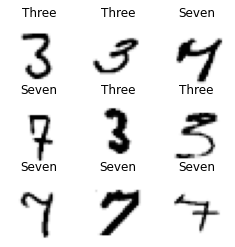

In [0]:
labels_dict = {'3':'Three','7':'Seven'}
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=[parent_label,labels_dict.__getitem__])

dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

### Why is there no `get_x` in the above DataBlocks example?

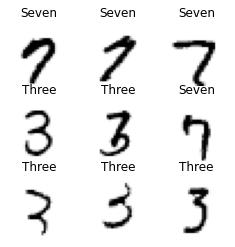

In [0]:
labels_dict = {'3':'Three','7':'Seven'}
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=[parent_label,labels_dict.__getitem__])

dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

The answer lies in the ??ImageBlock, we saw `type_tfms=cls.create`. More precisely in our case `type_tfms=PILImageBW.create`.  
Quick look at `PILImageBW.create` shows that it can read an image from the following options - `(Path,str,Tensor,ndarray,bytes)`.     

In [0]:
#reading from a path
im = PILImageBW.create(get_image_files(path)[0])
im

In [0]:
#reading from an ndarray
ndarray_type=array(im)
im = PILImageBW.create(ndarray_type)
im

So why is there no `get_x`?   
`get_image_files` returns all your items from the source ie the paths to the different images.  `get_x` and `get_y` (list of `getters`) are used to get your `x`s and `y`s from the result of `get_image_files` and they both default to `noop`. This is why when `get_image_files` return filenames, we don’t pass a `get_x`.



# Regression
## Predict a list of numbers. 
(ImageBlock, RegressionBlock(c_out=4)   
`(image_id,	[healthy	multiple_diseases	rust	scab])`.  


Here we deal with a single leaf image and we have to predict whether the leaf is healthy, has multiple diseases, has rust, has scab.   
So we have a input image and 4 columns to predict.  
In the [evaluation](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/evaluation) they say `For each image_id in the test set, you must predict a probability for each target variable. ` so we'll set it up as a regression problem.  
The [tiny data](https://github.com/rekil156/data/blob/master/small_data) is available here.  
The [full data](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data) is available here.

In [0]:
#hide 
#upload you data to the `content` folder 
!unzip -q plant.zip
# Allow [A]All over-write (i may have some multiplt .DS_store files)

In [0]:
#hide_input
train = pd.read_csv('/content/plant/train.csv')
train.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


We need to create a tuple ie `(x,y)`. Let's create it like this `(image_id,	[healthy	multiple_diseases	rust	scab])`.  
Let's create a new column `combined` which is a list of the dependent variables. (This is not the only way to solve this problem)

In [0]:
#hide_input
train['combined'] = train[['healthy','multiple_diseases','rust','scab']].values.tolist()
train.head(2)

,image_id,healthy,multiple_diseases,rust,scab,combined
0,Train_0,0,0,0,1,"[0, 0, 0, 1]"
1,Train_1,0,1,0,0,"[0, 1, 0, 0]"


### 'show_batch' needs to be fixed to show a list
For `show_batch` to work we need to add the ability for a list to have `show_title`(open in Collab)

In [0]:
#hide
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [0]:
#hide
class ToListTensor(Transform):
    "Transform to int tensor"
    # order = 10 #Need to run after PIL transforms on the GPU
    _show_args = {'label': 'text'}
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    # def decodes(self, o): return TitledNumberShort(o)
    def decodes(self, o): return TitledList(o.numpy().astype(int))

We'll use a ImageBlock and RegressionBlock.     
For the RegressionBlock, here we need to set `c_out`.  
And we add `ToListTensor` to the `get_y`

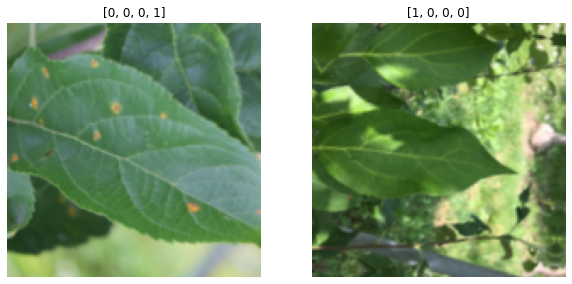

In [0]:
plant = DataBlock(blocks =(ImageBlock, RegressionBlock(c_out=4)),
                  get_x = ColReader('image_id', pref=f'/content/plant/plant_tiny/',suff='.jpg'),
                  get_y = [ColReader('combined'),ToListTensor],
                  splitter =RandomSplitter(),
                  item_tfms=[Resize(150)],
                  batch_tfms = [*aug_transforms()],
                  )
dls = plant.dataloaders(train,bs=2)
dls.show_batch(nrows=1,ncols=2,figsize=(10,10))

I have a full pipeline [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Multi_Point_Regression.ipynb)

# 4 channel input image    

[Kaggle Competition](https://www.kaggle.com/c/human-protein-atlas-image-classification)   
This was worked on by a group of us-
@akashpalrecha, @aman, @init_27 @barnacl(am i missing anyone else please let me know)  
Tiny version of the dataset is available [here](https://github.com/rekil156/data)

Each image in the dataset is a single channel black and white image.  
We need to combine 4 of them to make a 4-channel image.   
Given this 4-channel image we want to predict multiple categories.  

We have:  
fname_red.png  
fname_green.png  
fname_blue.png   
fname_yellow.png  
These four need to be stacked to form one single 4-channel image.  
This example gives a clear understanding of when to use get_items, get_x, get_y.


In [0]:
#hide 
#upload the data to the `content` folder. Data is available here - https://github.com/rekil156/data/blob/master/small_data
#grab the plant folder for this section
!unzip -q atlas.zip
# Allow [A]All over-write (i may have some multiplt .DS_store files)

[atlas.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of atlas.zip or
        atlas.zip.zip, and cannot find atlas.zip.ZIP, period.


In [0]:
data_path = Path('/content/atlas/atlas_tiny')
files = sorted(get_image_files(data_path))
files[:4]

[Path('/content/atlas/atlas_tiny/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png'),
 Path('/content/atlas/atlas_tiny/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png'),
 Path('/content/atlas/atlas_tiny/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png')]

In [0]:
#pick every 4th file (after it has been sorted)
list(range(0, len(files), 4))[:20]

[0, 4, 8, 12, 16, 20]

In [0]:
def get_4th_file(path):
    files = sorted(get_image_files(path))
    return files[slice(0, len(files), 4)]#return every 4th file. 

In [0]:
#hide
get_4th_file(data_path)

[Path('/content/atlas/atlas_tiny/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/002679c2-bbb6-11e8-b2ba-ac1f6b6435d0_blue.png'),
 Path('/content/atlas/atlas_tiny/0032a07e-bba9-11e8-b2ba-ac1f6b6435d0_blue.png')]

In [0]:
def stack_4_imgs(fname):
    fname = fname.stem.split('_')[0]
    colors = ['red','green','blue','yellow']
    img = [Image.open('/content/atlas/atlas_tiny/'+fname+'_'+color+'.png') for color in colors]
    #the img dims are [wd,ht,ch], we want to stack on channel axis
    x = np.stack(img, axis=-1)
    return PILImage.create(x)#x

In [0]:
#hide_input
df = pd.read_csv("/content/atlas/train.csv")
df.set_index("Id", inplace=True)
df.head(2)

,Target
Id,
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,16 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,7 1 2 0


In [0]:
def get_y(path, df=df):
    fn = path.stem.split("_")[0]
    return df.loc[fn].values[0].split(" ")

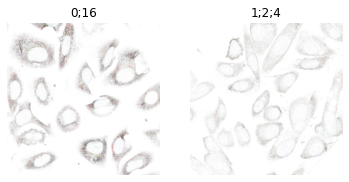

In [0]:
atlas = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_items=get_4th_file, 
                  get_x=stack_4_imgs,
                  get_y=get_y,
                  batch_tfms=[Normalize()]
                 )
dls = atlas.dataloaders(data_path,bs=2)
dls.show_batch()

Check out the `DataBlock.summary` function